Connecting to radio://0/80/2M/E7E7E7E701
Connected to radio://0/80/2M/E7E7E7E701
Connecting to radio://0/80/2M/E7E7E7E702
Connected to radio://0/80/2M/E7E7E7E702
radio://0/80/2M/E7E7E7E702 : Waiting for estimator to find position...
radio://0/80/2M/E7E7E7E701 : Waiting for estimator to find position...
radio://0/80/2M/E7E7E7E701radio://0/80/2M/E7E7E7E702  : Position found.
: Position found.
radio://0/80/2M/E7E7E7E701 : Waiting for parameters to be downloaded...
radio://0/80/2M/E7E7E7E701 : Parameters downloaded.
radio://0/80/2M/E7E7E7E702 : Waiting for parameters to be downloaded...
radio://0/80/2M/E7E7E7E702 : Parameters downloaded.
Starting in 3 seconds...
radio://0/80/2M/E7E7E7E701 : Running task [fly_sequence]...
radio://0/80/2M/E7E7E7E702 : Running task [mirror]...
radio://0/80/2M/E7E7E7E701 : Setting position (0, 0, 0.7)
radio://0/80/2M/E7E7E7E701 : Setting position (0.2, 0.2, 0.7)
radio://0/80/2M/E7E7E7E701 : Setting position (0.2, -0.2, 0.9)
radio://0/80/2M/E7E7E7E701 : Setting

<ipython-input-1-4fc949160166>:257: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


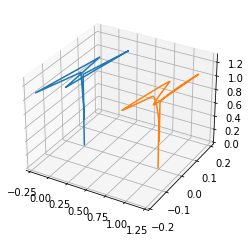

In [1]:
# -*- coding: utf-8 -*-
#
"""
Simple example that connects to two crazyflies and sets the initial position.
First crazyflie flies towards specified positions in sequence using onboard velocity control.
The second crazyflie follows the first.
Works best with lighthouse/loco positioning systems.
"""
import math
import time

# Primarily see __init__.py in cfsim/crazyflie/ to add functionality to simulator
import cfsim.crtp as crtp
from cfsim.crazyflie.log import LogConfig
from cfsim.crazyflie.swarm import Swarm, CachedCfFactory
from cfsim.crazyflie.syncLogger import SyncLogger

# import cflib.crtp as crtp
# from cflib.crazyflie.log import LogConfig
# from cflib.crazyflie.swarm import Swarm, CachedCfFactory
# from cflib.crazyflie.syncLogger import SyncLogger

logdata = {}
""" SETTINGS """

# URIs to the Crazyflies to connect to
uris = [
	'radio://0/80/2M/E7E7E7E701',
	'radio://0/80/2M/E7E7E7E702',
	# 'radio://0/90/2M/E7E7E7E703',
	# 'radio://0/90/2M/E7E7E7E704',
]

# Sequence for the first crazyflie to fly
#    x    y    z
sequence = [
    (0, 0, 0.7),
    (0.2, 0.2, 0.7),
    (0.2, -0.2, 0.9),
    (-0.2, 0.2, 0.5),
    (-0.2, -0.2, 0.7),
    (0, 0, 0.7),
    (0, 0, 0.2),
]
# Starting Positions dict, keyed by uri
#    x    y    z
initialPositions = {
#    uris[0]: (2.0, 1.4, 0.4),
#    uris[1]: (3.0, 1.4, 0.4),
    uris[0]: (0.0, 0.0, 0.4),
    uris[1]: (1.0, 0.0, 0.4),
}
# Which task should be performed by the different crazyflies
tasks = {
    uris[0]: 'fly_sequence',
    uris[1]: 'mirror', # Mirror the first crazyflie
}

# Used to keep track of current position of the crazyflies
currentPositions = initialPositions.copy() # shallow copy


""" SETUP FUNCTIONS """

def wait_for_position_estimator(scf):
    print(scf.cf.link_uri, ': Waiting for estimator to find position...')

    log_config = LogConfig(name='Kalman Variance', period_in_ms=500)
    log_config.add_variable('kalman.varPX', 'float')
    log_config.add_variable('kalman.varPY', 'float')
    log_config.add_variable('kalman.varPZ', 'float')

    var_y_history = [1000] * 10
    var_x_history = [1000] * 10
    var_z_history = [1000] * 10

    threshold = 0.001

    with SyncLogger(scf, log_config) as logger:
        for log_entry in logger:
            data = log_entry[1]

            var_x_history.append(data['kalman.varPX'])
            var_x_history.pop(0)
            var_y_history.append(data['kalman.varPY'])
            var_y_history.pop(0)
            var_z_history.append(data['kalman.varPZ'])
            var_z_history.pop(0)

            min_x = min(var_x_history)
            max_x = max(var_x_history)
            min_y = min(var_y_history)
            max_y = max(var_y_history)
            min_z = min(var_z_history)
            max_z = max(var_z_history)

            if (max_x - min_x) < threshold and (
                    max_y - min_y) < threshold and (
                    max_z - min_z) < threshold:
                break
    print(scf.cf.link_uri, ': Position found.')

def set_initial_position(scf):
    initial = initialPositions[scf.cf.link_uri]
    scf.cf.param.set_value('kalman.initialX', initial[0])
    scf.cf.param.set_value('kalman.initialY', initial[1])
    scf.cf.param.set_value('kalman.initialZ', initial[2])

def reset_estimator(scf):
    scf.cf.param.set_value('kalman.resetEstimation', '1')
    time.sleep(0.1)
    scf.cf.param.set_value('kalman.resetEstimation', '0')
    wait_for_position_estimator(scf)

def wait_for_param_download(scf):
    print(scf.cf.link_uri, ': Waiting for parameters to be downloaded...')
    while not scf.cf.param.is_updated:
        time.sleep(1.0)
    print(scf.cf.link_uri, ': Parameters downloaded.')

# Start saving position data
def start_position_callback(scf):
    # Set position logging configuration
    log_config = LogConfig(name='Position', period_in_ms=50)
    log_config.add_variable('kalman.stateX', 'float')
    log_config.add_variable('kalman.stateY', 'float')
    log_config.add_variable('kalman.stateZ', 'float')

    def position_callback(timestamp, data, log_config):
        x = data['kalman.stateX']
        y = data['kalman.stateY']
        z = data['kalman.stateZ']
        currentPositions[scf.cf.link_uri] = (x,y,z)
        # print(scf.cf.link_uri, ': Position ', (x,y,z))
        logdata[scf.cf.link_uri]['x'].append(x)
        logdata[scf.cf.link_uri]['y'].append(y)
        logdata[scf.cf.link_uri]['z'].append(z)

    scf.cf.log.add_config(log_config)
    log_config.data_received_cb.add_callback(position_callback)
    log_config.start()


""" TASKS """

def fly_to(cf,position):
    # Compute velocity (P controller)
    vmax = 0.4 # Maximum velocity 
    K = 1 # Controller gain
    xe = currentPositions[cf.link_uri][0]-position[0]
    ye = currentPositions[cf.link_uri][1]-position[1]
    ze = currentPositions[cf.link_uri][2]-position[2]
    d = math.sqrt(xe**2+ye**2+ze**2)

    if d > 1e-4:
        v = K*d;
        v = min(vmax,v)
        vx = -v*xe/d
        vy = -v*ye/d
        vz = -v*ze/d
    else:
        vx = 0.0
        vy = 0.0
        vz = 0.0

    # Send velocity
    cf.commander.send_velocity_world_setpoint(vx, vy, vz, 0)

# Main loop each crazyflie runs until completion
def run_task(scf):
    try:
        cf = scf.cf
        task = tasks[cf.link_uri]
        print(cf.link_uri, ': Running task [%s]...' % (task))

        if task == 'fly_sequence':
            startTime = time.time()
            sequencePos = -1
            position = sequence[0]
            while True:
                # Determine position reference based on time
                relativeTime = time.time()-startTime
                if relativeTime > (sequencePos+1)*5: # Fly to each point for 5 seconds
                    sequencePos += 1

                    if sequencePos >= len(sequence):
                        break
                    position = sequence[sequencePos]
                    print(cf.link_uri, ': Setting position {}'.format(position))

                # Desired position
                initial = initialPositions[cf.link_uri]
                x = position[0] + initial[0]
                y = position[1] + initial[1]
                z = position[2] + initial[2]
                fly_to(cf,(x,y,z))
                time.sleep(0.01)

        elif task == 'mirror':
            while True:
                if tasks[uris[0]] == 'landing':
                    break

                initial_self = initialPositions[cf.link_uri]
                initial_target = initialPositions[uris[0]]
                pos_target = currentPositions[uris[0]]
                x = pos_target[0] - initial_target[0] + initial_self[0]
                y = pos_target[1] - initial_target[1] + initial_self[1]
                z = pos_target[2] - initial_target[2] + initial_self[2]
                fly_to(cf,(x,y,z))
                time.sleep(0.1)

        else:
            print(cf.link_uri, ': Task [%s] not defined' % (task))

        tasks[cf.link_uri] = 'landing'
        print(cf.link_uri, ': Landing')
        time_landing = (currentPositions[cf.link_uri][2]-initialPositions[cf.link_uri][2])/0.1
        for i in range(math.floor(10*time_landing)):
            cf.commander.send_velocity_world_setpoint(0, 0, -0.1, 0)
            time.sleep(0.1)
        cf.commander.send_stop_setpoint()
        # Make sure that the last packet leaves before the link is closed
        # since the message queue is not flushed before closing
        time.sleep(1.0)

        print(cf.link_uri, ': Finished task [%s].' % (task))
    except Exception as e:
        print(e)

if __name__ == '__main__':
    for uri in uris:
        logdata[uri] = {'x':[],'y':[],'z':[]}

    crtp.init_drivers(enable_debug_driver=False)

    with Swarm(uris, factory=CachedCfFactory(rw_cache='./cache')) as swarm:
        # Set initial position and reset kalman filters
        swarm.parallel_safe(set_initial_position)
        swarm.parallel_safe(set_initial_position)
        swarm.parallel_safe(reset_estimator)
        # Wait for all crazyflies
        swarm.parallel_safe(wait_for_param_download)
        # Start position callback
        swarm.parallel_safe(start_position_callback)
        print('Starting in 3 seconds...')
        time.sleep(3)
        swarm.parallel_safe(run_task)

        print("END")


    # Plot
    from mpl_toolkits.mplot3d import Axes3D
    import matplotlib.pyplot as plt
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    for uri in uris:
        ax.plot(logdata[uri]['x'], logdata[uri]['y'], logdata[uri]['z'])
    plt.show( )